In [1]:
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm as tqdm
from keras.models import load_model
from keras import backend as K
from datetime import datetime

from Dental_Tool.Inception_v3 import Custom_Inception_V3, Simple_Inception
from Dental_Tool.Inception import create_inception_v4
from Dental_Tool.Data_processing import *
from Dental_Tool.Dental_Model import *
from Dental_Tool.Process_results import *
from Dental_Tool.Dataloader import *
from Dental_Tool.KFold_v3 import *

import keras.backend as K 
import matplotlib.pyplot as plt
import numpy as np
import keras
import time

Using TensorFlow backend.


In [2]:
directory = [ 
                "Dental_Data/PBL/10_interdental_20200901_Max_4", 
                "Dental_Data/PBL/10_interdental_20200901_Max_4_Flip", 
                "Dental_Data/PBL/10_interdental_clahe_20200901_Max_4", 
                "Dental_Data/PBL/10_interdental_clahe_20200901_Max_4_Flip",
#                 "Dental_Data/PBL/10_interdental_20200901_Max_4_Shear",
#                 "Dental_Data/PBL/10_interdental_clahe_20200901_Max_4_Shear"
            ]

# directory = [ 
#                 "Dental_Data/PBL/10_20200901_Original", 
#                 "Dental_Data/PBL/10_20200901_Flip_Original", 
#                 "Dental_Data/PBL/10_clahe_20200901_Original", 
#                 "Dental_Data/PBL/10_clahe_20200901_Flip_Original"
#             ]

# directory = [ 
#                 "Dental_Data/PBL/10_20200901", 
#                 "Dental_Data/PBL/10_20200901_Flip", 
#                 "Dental_Data/PBL/10_clahe_20200901", 
#                 "Dental_Data/PBL/10_clahe_20200901_Flip"
#             ]

directory = [ i + "/mapping.json" for i in directory]
argscale_num = len(directory) * 20 

data = load_json(directory, interdental=True)

# dataset = json_2_dataframe_PBL(data)
dataset = json_2_dataframe_PBL_inderdental(data)

# groups = [ tooth_table for ori_src, table in dataset.groupby("ori_src") for src, teeth_table in table.groupby("source") for src_side, tooth_table in teeth_table.groupby("side") ]
# dataset = pd.concat(groups).reset_index(drop=True)

dataset

,Path,State,Class,ori_src,source,tooth_num,tooth_type,side,angle
0,Dental_Data/PBL/10_interdental_20200901_Max_4/...,1,0,20200901_Max_4/08-09-15-828_000408 102419 x,20200901_Max_4/08-09-15-828_000408 102419 x_6,6,2,20200901_Max_4/08-09-15-828_000408 102419 x_6_L,-10
1,Dental_Data/PBL/10_interdental_20200901_Max_4_...,1,0,Max_4_Flip/08-09-15-828_000408 102419 x,Max_4_Flip/08-09-15-828_000408 102419 x_6,6,2,Max_4_Flip/08-09-15-828_000408 102419 x_6_L,-10
2,Dental_Data/PBL/10_interdental_clahe_20200901_...,1,0,20200901_Max_4/08-50-47-804_000408 102419 x,20200901_Max_4/08-50-47-804_000408 102419 x_6,6,2,20200901_Max_4/08-50-47-804_000408 102419 x_6_L,-10
3,Dental_Data/PBL/10_interdental_clahe_20200901_...,1,0,Max_4_Flip/08-50-47-804_000408 102419 x,Max_4_Flip/08-50-47-804_000408 102419 x_6,6,2,Max_4_Flip/08-50-47-804_000408 102419 x_6_L,-10
4,Dental_Data/PBL/10_interdental_20200901_Max_4/...,1,0,20200901_Max_4/08-09-15-844_000408 102419 x,20200901_Max_4/08-09-15-844_000408 102419 x_6,6,2,20200901_Max_4/08-09-15-844_000408 102419 x_6_R,-10
...,...,...,...,...,...,...,...,...,...
703835,Dental_Data/PBL/10_interdental_clahe_20200901_...,2,1,4_Flip/09-28-06-956_S594966_2 091718 x,4_Flip/09-28-06-956_S594966_2 091718 x_26,26,3,4_Flip/09-28-06-956_S594966_2 091718 x_26_L,9
703836,Dental_Data/PBL/10_interdental_20200901_Max_4/...,1,0,Max_4/08-50-31-686_S594966_2 091718 x,Max_4/08-50-31-686_S594966_2 091718 x_26,26,3,Max_4/08-50-31-686_S594966_2 091718 x_26_R,9
703837,Dental_Data/PBL/10_interdental_20200901_Max_4_...,1,0,4_Flip/08-50-31-686_S594966_2 091718 x,4_Flip/08-50-31-686_S594966_2 091718 x_26,26,3,4_Flip/08-50-31-686_S594966_2 091718 x_26_R,9
703838,Dental_Data/PBL/10_interdental_clahe_20200901_...,1,0,Max_4/09-28-06-964_S594966_2 091718 x,Max_4/09-28-06-964_S594966_2 091718 x_26,26,3,Max_4/09-28-06-964_S594966_2 091718 x_26_R,9


stage 0: 106240, stage 1: 196640, stage 2: 84880, stage 3: 34400
stage 0: 35360, stage 1: 65920, stage 2: 27840, stage 3: 11440
stage 0: 35520, stage 1: 65760, stage 2: 28240, stage 3: 11600
Training dataset: 137600,Validation dataset: 45760, Testing dataset: 46400
set()
set()
set()
Fold 1: loading Inception ......
Fold 1: loading Done, cost 7.953654766082764 seconds
Epoch 1/15
2150/2150 [==============================] - 2148s 999ms/step - loss: 0.3556 - accuracy: 0.8410 - val_loss: 0.3949 - val_accuracy: 0.8635

Epoch 00001: val_accuracy improved from -inf to 0.86351, saving model to Results/Inception_Binary_Fold_520201105-160814/Fold_1/Inception_Fold_1/parameter/weights-improvement-01-0.8635.hdf5
Epoch 2/15
2150/2150 [==============================] - 612s 285ms/step - loss: 0.1676 - accuracy: 0.9311 - val_loss: 0.3573 - val_accuracy: 0.8571

Epoch 00002: val_accuracy did not improve from 0.86351
Epoch 3/15
2150/2150 [==============================] - 614s 286ms/step - loss: 0.0752 

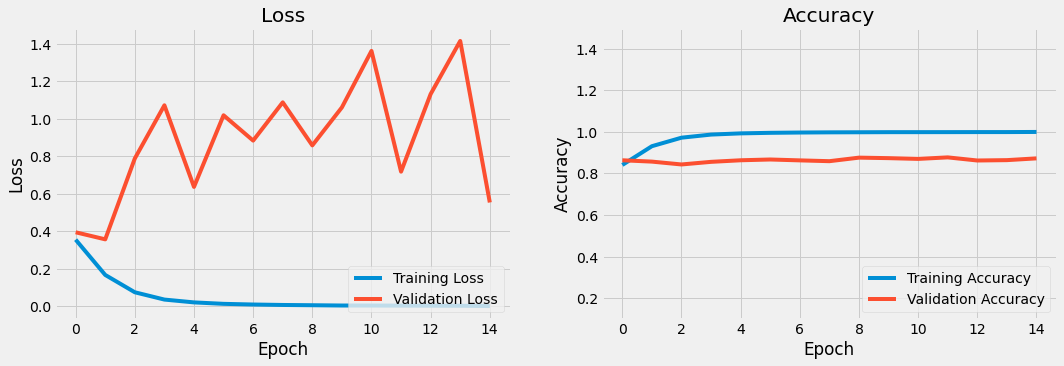

loading Results/Inception_Binary_Fold_520201105-160814/Fold_1/Inception_Fold_1/parameter\weights-improvement-12-0.8774.hdf5 ......
loading Done, cost 61.222140312194824 seconds
725/725 [==============================] - 976s 1s/step
Accuracy  = 83.61 %


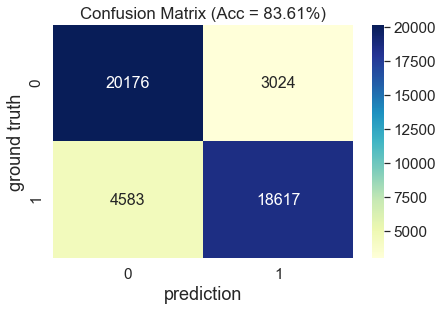

  Class 0 Class 1 Class 2  Acc
0   11260     340       0  97%
1    8916    2684       0  77%
2    3721    7879       0  68%
3     862   10738       0   0%
stage 0: 106080, stage 1: 196800, stage 2: 84480, stage 3: 34480
stage 0: 35520, stage 1: 65760, stage 2: 28240, stage 3: 11360
stage 0: 35520, stage 1: 65760, stage 2: 28240, stage 3: 11600
Training dataset: 137920,Validation dataset: 45440, Testing dataset: 46400
set()
set()
set()
Fold 2: loading Inception ......
Fold 2: loading Done, cost 3.359614610671997 seconds
Epoch 1/15
2155/2155 [==============================] - 2395s 1s/step - loss: 0.2865 - accuracy: 0.8753 - val_loss: 0.3007 - val_accuracy: 0.8482

Epoch 00001: val_accuracy improved from -inf to 0.84824, saving model to Results/Inception_Binary_Fold_520201105-160814/Fold_2/Inception_Fold_2/parameter/weights-improvement-01-0.8482.hdf5
Epoch 2/15
2155/2155 [==============================] - 2002s 929ms/step - loss: 0.1257 - accuracy: 0.9502 - val_loss: 0.9200 - val_accurac

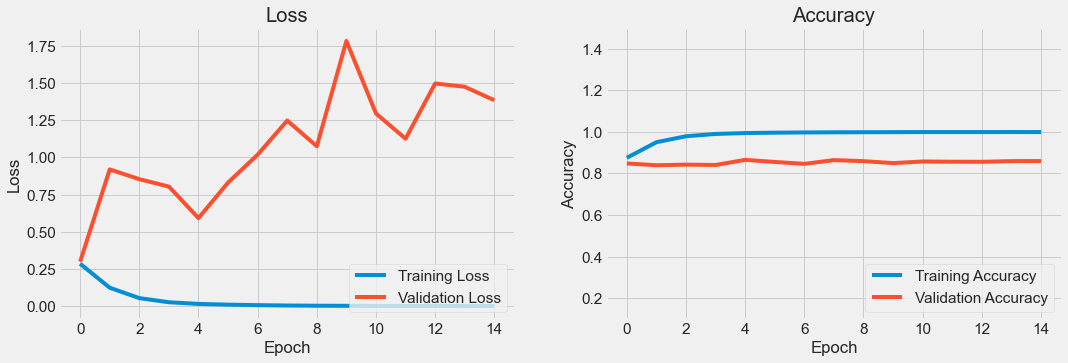

loading Results/Inception_Binary_Fold_520201105-160814/Fold_2/Inception_Fold_2/parameter\weights-improvement-05-0.8654.hdf5 ......
loading Done, cost 101.57045793533325 seconds
725/725 [==============================] - 1329s 2s/step
Accuracy  = 75.42 %


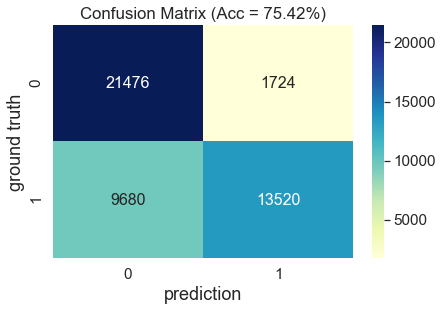

  Class 0 Class 1 Class 2  Acc
0   11315     285       0  98%
1   10161    1439       0  88%
2    6698    4902       0  42%
3    2982    8618       0   0%
stage 0: 106240, stage 1: 196640, stage 2: 84880, stage 3: 34400
stage 0: 35520, stage 1: 65760, stage 2: 28240, stage 3: 11360
stage 0: 35360, stage 1: 65920, stage 2: 27840, stage 3: 11680
Training dataset: 137600,Validation dataset: 45440, Testing dataset: 46720
set()
set()
set()
Fold 3: loading Inception ......
Fold 3: loading Done, cost 3.4939661026000977 seconds
Epoch 1/15
2150/2150 [==============================] - 3097s 1s/step - loss: 0.2837 - accuracy: 0.8772 - val_loss: 0.5974 - val_accuracy: 0.7760

Epoch 00001: val_accuracy improved from -inf to 0.77601, saving model to Results/Inception_Binary_Fold_520201105-160814/Fold_3/Inception_Fold_3/parameter/weights-improvement-01-0.7760.hdf5
Epoch 2/15
2150/2150 [==============================] - 2468s 1s/step - loss: 0.1271 - accuracy: 0.9488 - val_loss: 0.8125 - val_accuracy:

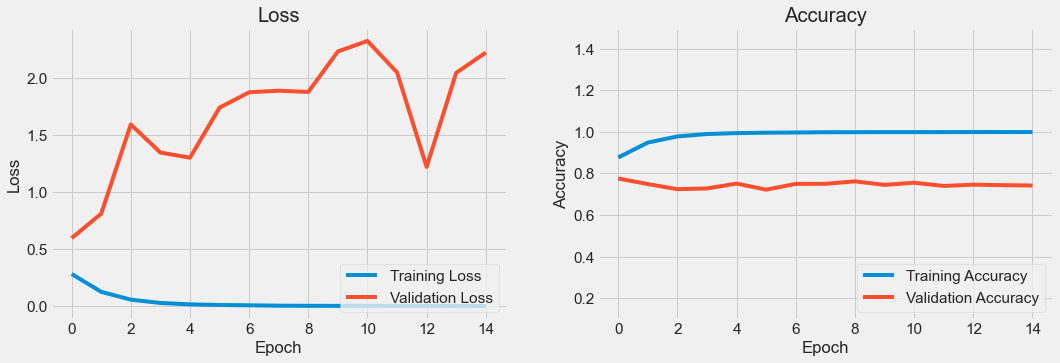

loading Results/Inception_Binary_Fold_520201105-160814/Fold_3/Inception_Fold_3/parameter\weights-improvement-01-0.7760.hdf5 ......
loading Done, cost 117.12730956077576 seconds
730/730 [==============================] - 1202s 2s/step
Accuracy  = 81.85 %


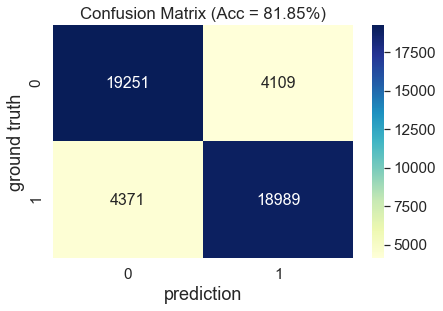

  Class 0 Class 1 Class 2  Acc
0   10946     734       0  94%
1    8305    3375       0  71%
2    3169    8511       0  73%
3    1202   10478       0   0%
stage 0: 106400, stage 1: 197440, stage 2: 84400, stage 3: 34160
stage 0: 35360, stage 1: 65920, stage 2: 27840, stage 3: 11440
stage 0: 35360, stage 1: 64960, stage 2: 28720, stage 3: 11840
Training dataset: 136640,Validation dataset: 45760, Testing dataset: 47360
set()
set()
set()
Fold 4: loading Inception ......
Fold 4: loading Done, cost 3.407536745071411 seconds
Epoch 1/15
2135/2135 [==============================] - 2268s 1s/step - loss: 0.3309 - accuracy: 0.8513 - val_loss: 0.3682 - val_accuracy: 0.7775

Epoch 00001: val_accuracy improved from -inf to 0.77749, saving model to Results/Inception_Binary_Fold_520201105-160814/Fold_4/Inception_Fold_4/parameter/weights-improvement-01-0.7775.hdf5
Epoch 2/15
2135/2135 [==============================] - 939s 440ms/step - loss: 0.1548 - accuracy: 0.9377 - val_loss: 0.3129 - val_accuracy

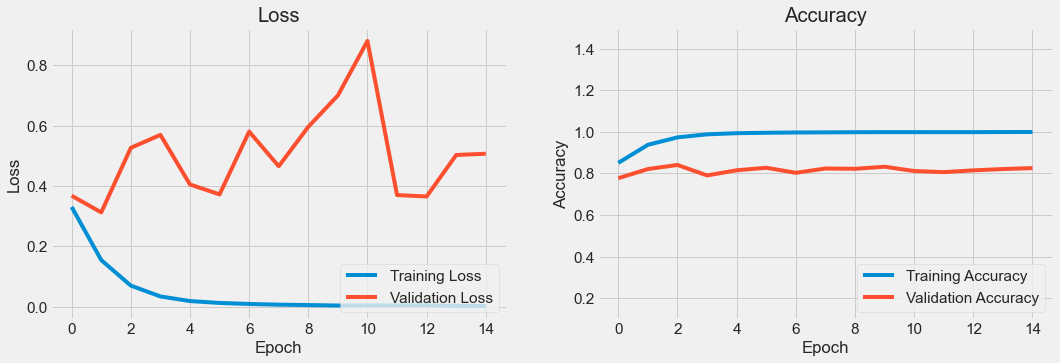

loading Results/Inception_Binary_Fold_520201105-160814/Fold_4/Inception_Fold_4/parameter\weights-improvement-03-0.8410.hdf5 ......
loading Done, cost 120.47926115989685 seconds
740/740 [==============================] - 1332s 2s/step
Accuracy  = 84.92 %


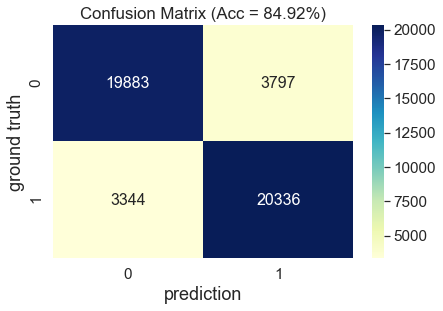

  Class 0 Class 1 Class 2  Acc
0   10826    1014       0  91%
1    9057    2783       0  76%
2    2868    8972       0  76%
3     476   11364       0   0%
stage 0: 106400, stage 1: 197440, stage 2: 84400, stage 3: 34160
stage 0: 35360, stage 1: 64960, stage 2: 28720, stage 3: 11600
stage 0: 35360, stage 1: 65920, stage 2: 27840, stage 3: 11680
Training dataset: 136640,Validation dataset: 46400, Testing dataset: 46720
set()
set()
set()
Fold 5: loading Inception ......
Fold 5: loading Done, cost 4.629807949066162 seconds
Epoch 1/15
2135/2135 [==============================] - 3009s 1s/step - loss: 0.3603 - accuracy: 0.8364 - val_loss: 0.4871 - val_accuracy: 0.8023

Epoch 00001: val_accuracy improved from -inf to 0.80226, saving model to Results/Inception_Binary_Fold_520201105-160814/Fold_5/Inception_Fold_5/parameter/weights-improvement-01-0.8023.hdf5
Epoch 2/15
2135/2135 [==============================] - 2264s 1s/step - loss: 0.1742 - accuracy: 0.9284 - val_loss: 0.4262 - val_accuracy: 

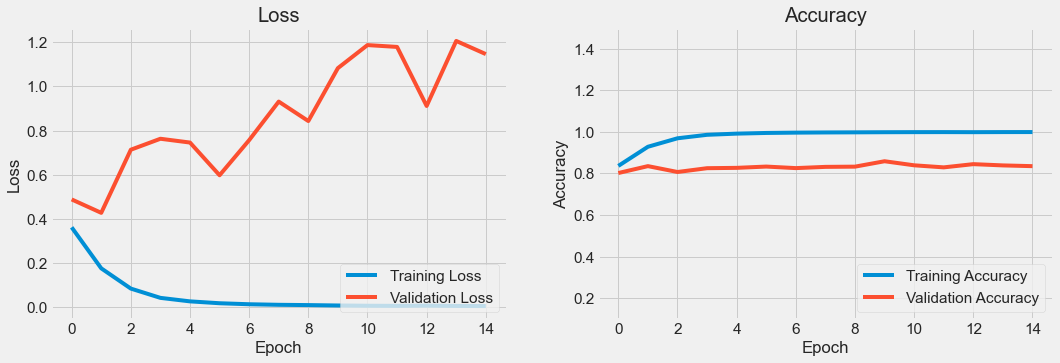

loading Results/Inception_Binary_Fold_520201105-160814/Fold_5/Inception_Fold_5/parameter\weights-improvement-10-0.8588.hdf5 ......
loading Done, cost 157.7139744758606 seconds
730/730 [==============================] - 1314s 2s/step
Accuracy  = 88.45 %


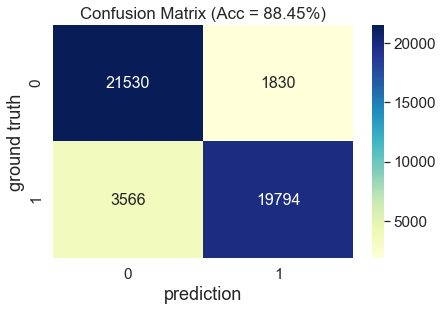

  Class 0 Class 1 Class 2  Acc
0   11226     454       0  96%
1   10304    1376       0  88%
2    3092    8588       0  74%
3     474   11206       0   0%


In [3]:
# all_models = { "CNN_Net": CNN_Net, "Inception": Inception, "ResNet": ResNet }
root_dir  =  "Inception_Binary_Fold_5" + datetime.now().strftime("%Y%m%d-%H%M%S")

init_directory(f"Results/{root_dir}/table")

# train_dataset.to_csv("Results/%s/table/train_dataset.csv" % root_dir, index=False)
# valid_dataset.to_csv("Results/%s/table/valid_dataset.csv" % root_dir, index=False)
# test_dataset.to_csv ("Results/%s/table/test_dataset.csv"  % root_dir, index=False)


# balance_dataset = pd.concat([train_dataset, valid_dataset, test_dataset])
# balance_dataset.to_csv("Results/%s/table/balance_dataset.csv"   % root_dir, index=False)

# model_info = ("Inception_v4_Net", create_inception_v4)
model_info = ("Inception", Inception)

performance_list = []

epochs     = 15
Fold_num = 5
num_params = 1
fold_data_num = 1

for train_dataset, valid_dataset, test_dataset, train_generator, valid_generator, test_generator in\
        K_Fold_balance_data_generator(dataset, argscale=argscale_num, k_fold_num=Fold_num, batch_size=64):
        
        K.clear_session()
        print(f"Training dataset: {len(train_dataset)},Validation dataset: {len(valid_dataset)}, Testing dataset: {len(test_dataset)}" )
        
        init_directory(f"Results/{root_dir}/Fold_{fold_data_num}/table")
           
        train_dataset.to_csv(f"Results/{root_dir}/Fold_{fold_data_num}/table/train_dataset.csv", index=False)
        valid_dataset.to_csv(f"Results/{root_dir}/Fold_{fold_data_num}/table/valid_dataset.csv", index=False)
        test_dataset.to_csv(f"Results/{root_dir}/Fold_{fold_data_num}/table/test_dataset.csv"  , index=False)
        
        print(set(train_dataset.source) & set(valid_dataset.source))
        print(set(valid_dataset.source) & set(test_dataset.source))
        print(set(train_dataset.source) & set(test_dataset.source))
        
        K.clear_session()
        best_models = None
        
        model_name, model_fnc = model_info
        K.clear_session()

        param_dir  = f"{model_name}_Fold_{fold_data_num}"
        print(f"Fold {fold_data_num}: loading {model_name} ......")

        start = time.time()
        model = model_fnc(input_shape=(200, 180, 1), classes=len(np.unique(train_dataset["Class"])))
        end = time.time()
        elapse = end - start
        print(f"Fold {fold_data_num}: loading Done, cost {elapse} seconds")


        init_directory(f"Results/{root_dir}/Fold_{fold_data_num}/{param_dir}/parameter")

        filepath="Results/%s/Fold_%d/%s/parameter/weights-improvement-{epoch:02d}-{val_accuracy:.4f}.hdf5" \
                    %(root_dir, fold_data_num, param_dir)
        checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

        # change 
        history = model.fit_generator(
                                generator=train_generator,
                                validation_data=valid_generator,
                                epochs=epochs,
                                workers=2,
                                shuffle=True,
                                verbose=1,
                                callbacks=[checkpoint]
                               )
        plot_result(history, f"Results/{root_dir}/Fold_{fold_data_num}/{param_dir}")

        K.clear_session()
        top_k_param = get_k_top_value(f"Results/{root_dir}/Fold_{fold_data_num}/{param_dir}/parameter",  k_th = num_params )
        best_param = top_k_param[0]
        
        K.clear_session()
        print(f"loading {best_param} ......")
        start = time.time()
        best_model = load_model(best_param)
        end = time.time()
        elapse = end - start
        print(f"loading Done, cost {elapse} seconds")

        test_predict = best_model.predict_generator(test_generator, verbose=1)
        test_predict = test_predict[:len(test_dataset)]
        test_result  = np.argmax(test_predict, axis=1)
        
        test_dataset["Predict"] = test_result
        
        K.clear_session()
        
        confusion = confusion_matrix(test_dataset.Class.astype('int'), test_result.astype('int'))
        curr_acc = (test_dataset.Class == test_dataset.Predict).mean() * 100
        title = "Accuracy  = {:5.2f} %".format(curr_acc)
        print(title)
        init_directory(f"Results/{root_dir}/Fold_{fold_data_num}/table")
        plot_confusion_matrix(confusion, len(np.unique(test_dataset.Class)), curr_acc, f"Results/{root_dir}/Fold_{fold_data_num}", 0)
        
        test_predict = np.round(test_predict, 2)
        
#         test_dataset[f"{model_name}_Prob"] = pd.Series(test_predict.tolist())
#         test_dataset[['Class_0_prob', 'Class_1_prob', 'Class_2_prob']] = pd.DataFrame(test_predict)
        test_dataset[['Class_0_prob', 'Class_1_prob']] = pd.DataFrame(test_predict)
        test_dataset["Predict"] = test_result
        
        test_dataset.to_csv(f"Results/{root_dir}/Fold_{fold_data_num}/table/test_predict.csv", index=False)
        detail = statistic(test_dataset)
        detail.to_csv(f"Results/{root_dir}/Fold_{fold_data_num}/table/cmx_stage.csv")
        print(detail)
        
        
        K.clear_session()
        
        performance_list.append(curr_acc)
        fold_data_num += 1

In [4]:
total_score = np.mean(performance_list)
title = "Accuracy  = {:5.2f} %".format(total_score)
title

'Accuracy  = 82.85 %'